# TP 2: Réseaux de neurones convolutionnels (2.1) 



Dans cette session, nous allons expérimenter avec les réseaux convolutionnels, toujours avec tensorflow/Keras. 

In [1]:
from IPython.display import clear_output
from ipywidgets import Output

In [2]:
#from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
from tensorflow import keras


import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF
from tqdm.keras import TqdmCallback

print(tf.__version__)

2.10.1


## 1. MNIST et la reconnaissance de chiffres

On reprend le même jeu de données qu'au TP1

### Rappel sur les CNN

Contrairement aux réseaux complètement connectés du TP1, les CNN utilisent des filtres de convolutions pour de l'image 2D, une petite sous-matrice (par exemple 3x3) qui applique un filtre à chaque pixel de l'image, permettant d'isoler
des caractéristiques locales de l'image. Une couche de CNN comporte plusieurs filtres en parallèles, parfois appelés
aussi `feature maps`.  Une illustration graphique d'une architecture de réseaux de CNN est présentée ici, avec plusieurs séries de filtres qui s'enchainent, et intégrant aussi des étapes de `pooling` : 

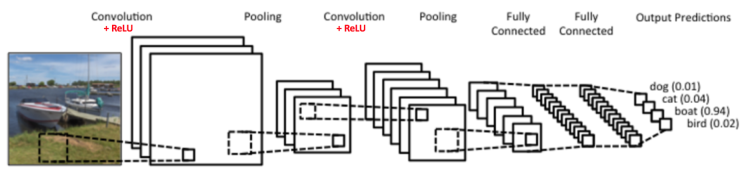


Les couches de pooling font aussi des transformations locales, en combinant les valeurs d'une sous-partie de l'image pour ne garder que la valeur maximale ("max pooling"), et réduisant donc la tailler de l'image. 


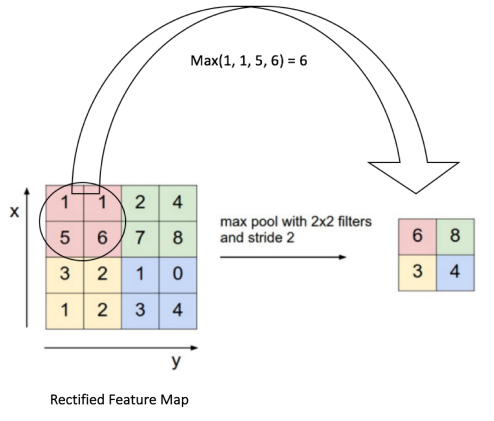


Notez que la dernière couche d'un tel réseau est généralement une couche complètement connectée, qui ramène vers la classification finale, selon le nombre de classes du problème. 

### Charger les données MNIST

Comme au TP1 : 

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Define pixel sizes of image (28x28)
(img_rows, img_cols) = (train_images.shape[1], train_images.shape[2])

Rappel du TP1: les données sont chargées dans des matrices numpy

* `train_images` et `train_labels` contient les données d'entrainement
* `test_images` et `test_labels` contient les données de test, pour évaluer les performances du modèel

Les images sont des matrices de 28x28 pixels avec une valeur entre 0 et 255. 

Les labels sont les entiers représentant les chiffres correspondant à chaque image. 


Les images de MNIST sont des matrices de taille 28x28 mais un CNN typique prend en entrée des objets tri-dimensionnels, la 3e correspondant au canal (par exemple RGB). 
Comme MNIST est en niveau de gris, il n'y a qu'un canal, mais il faut quand même convertir le 28x28 en 28x28x1. 

Ensuite le jeu de données (60000 instances pour le train) ajoutent une 4e dimension aux données. 

In [4]:
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

On vérifie tout ça : 

In [5]:
print('train_images shape:', train_images.shape)
print('test_images shape:', test_images.shape)
print(train_images.shape[0], 'train samples')
print(test_images.shape[0], 'test samples')

train_images shape: (60000, 28, 28, 1)
test_images shape: (10000, 28, 28, 1)
60000 train samples
10000 test samples


Comme au TP1, on ramène les valeurs entre 0 et 1

In [6]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

### Architecture du modèle

On va construire un premier réseau simple avec une seule couche convolutive, et un filtre de 3x3 pixels. 
On ajoute une couche de max-pooling qui prend des sous-fenêtres de 2x2 et garde donc la valeur maximale. 
Finalement, on "aplatit" la sortie pour avoir un vecteur de une seule dimension, en entrée d'une couche dense qui finit en sortie avec 10 classes, normalisée avec un softmax. 

We are now ready to define our network. Our first layer is a convolutional layer with a window size of 3x3 pixels. The convolutional layer consists of a single filter (1). Next, we have a maximum pooling layer with a window size of 2x2 pixels. The representation is flattened into a vector, so it can be propagated into a dense layer. Our pre-final layer is a dense layer with a hidden size of 20. And our final layer is a dense layer of size num_classes with softmax, which yields a probability distribution over our class labels.

In [7]:
"""
Initial model :
Test loss: 0.2785683572292328
Test accuracy: 0.9157999753952026

model = keras.Sequential([
    keras.layers.Conv2D(1, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
"""

model = keras.Sequential([
    keras.layers.Conv2D(1, kernel_size=(5, 5), padding="same" , activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    keras.layers.Conv2D(1, kernel_size=(5, 5), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation='sigmoid'),
    keras.layers.Dense(84, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

Comme au TP1 on compile le modèle: 

In [21]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

SyntaxError: incomplete input (3694470375.py, line 1)

Pour des modèles plus élaborés, on peut avoir un aperçu résumé de l'architecture avec : 

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 1)         26        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 1)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 1)         26        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 1)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 120)               3

Pourquoi la taille de la sortie de la convolution est-elle de 26x26 ? 

Comme au TP1 on peut maintenant entrainer le modèle, en gardant une partie des données pour la validation. 
On ajoute ici une visualisation de la loss pendant l'entrainement avec livelossplot. 

In [10]:
PLOT_CONTEXT = Output()
display(PLOT_CONTEXT)

from livelossplot.inputs.tf_keras import PlotLossesCallback
from typing import Dict
class PLK(PlotLossesCallback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def on_epoch_end(self, epoch: int, logs: Dict[str, float]):
        with PLOT_CONTEXT:
            super().on_epoch_end(epoch, logs)

Output()

In [11]:
history = model.fit(train_images, train_labels,
          batch_size=64,
          epochs=20,
          verbose=0,
          validation_split=0.1,
          callbacks=[PLK(), TqdmCallback()])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Quand on est satisfait des résultats, on peut évaluer sur le test et observer les prédictions: 

In [12]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2666099965572357
Test accuracy: 0.9211999773979187


In [13]:
predictions = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [14]:
def plot_image(i, predictions_array, true_label, img, class_names=None):
    if class_names == None:
        class_names = range(len(predictions_array))
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


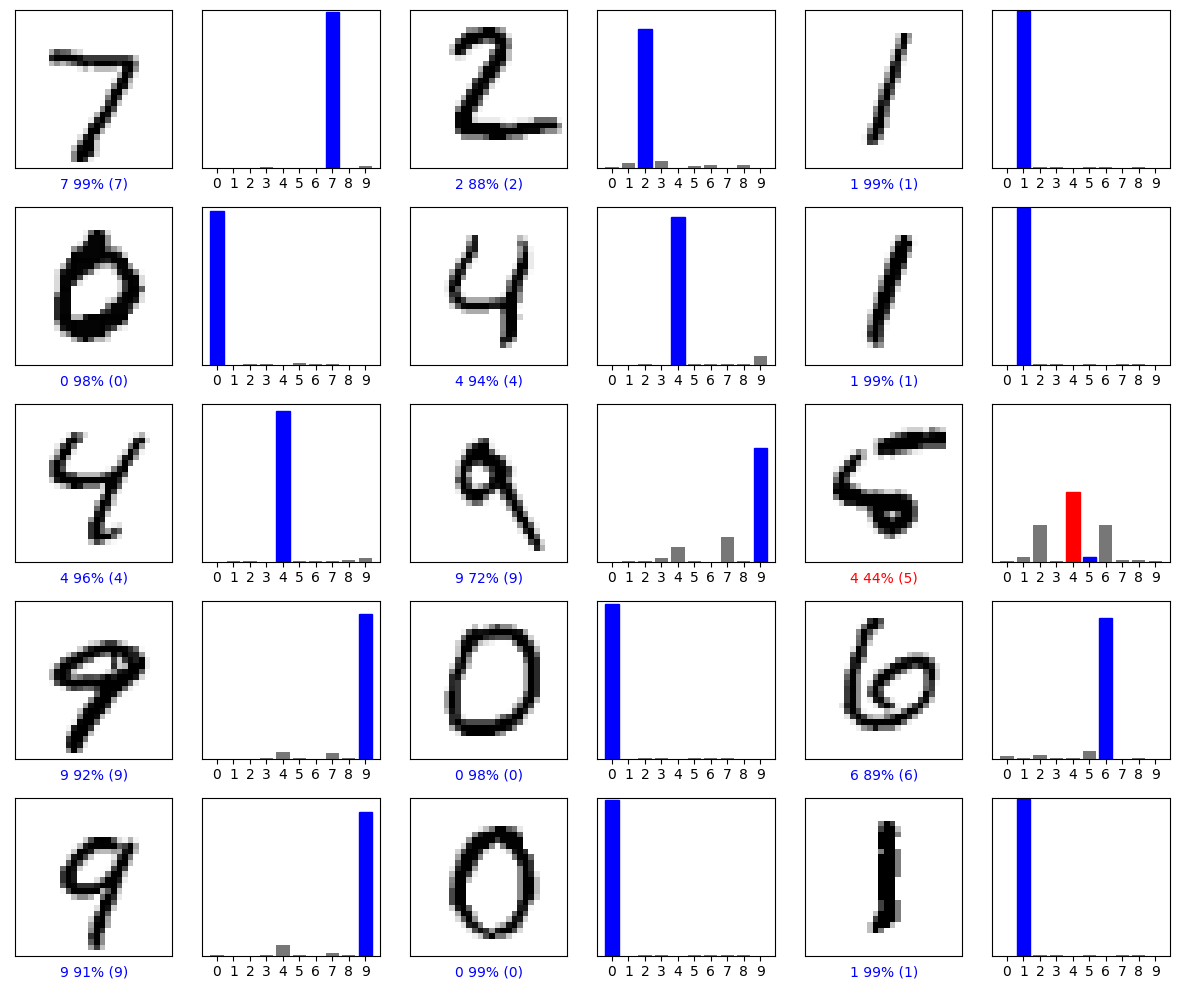

In [15]:
# prédictions correctes en bleu, incorrectes en rouge
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images[:,:,:,0])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()


### Exercice 1
Essayez d'améliorer la performance de base du réseau, en changeant notamment les paramètres propres aux CNN : 

* jouer sur le nombre de filtres / leur taille
* ajouter une 2e couche de convolution et de pooling 

Les autres facteurs considérés au TP1 peuvent encore jouer bien sur. former practical session.

## 2. Reconnaissance d’objets

### CIFAR10

On reprend CIFAR10 

In [16]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [17]:
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

In [18]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

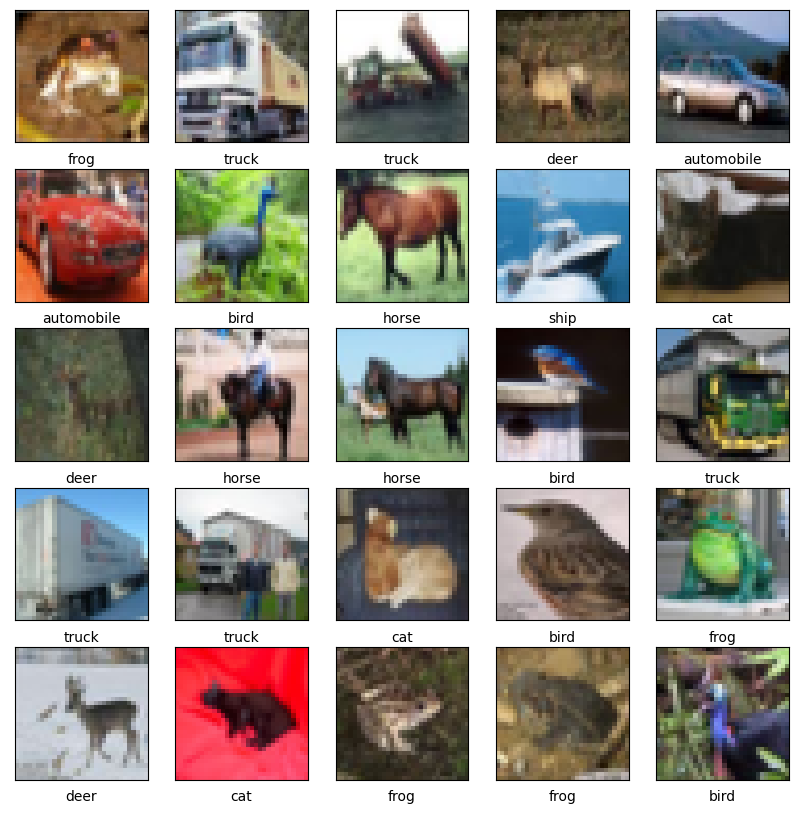

In [19]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Exercice 2

Construisez cette fois un CNN approprié pour la reconnaissnce d'objets sur les données CIFAR, en vous inspirant du modèle MNIST, et de ce que vous avez déjà fait au TP1. 

In [20]:
## a vous de jouer

In [ ]:
history = model.fit(train_images, train_labels,
          batch_size=64,
          epochs=20,
          verbose=0,
          validation_split=0.1,
          callbacks=[PLK(), TqdmCallback()])